In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import numpy as np
from collections import defaultdict
from autograd_lib import autograd_lib
from torch.utils.data import DataLoader, TensorDataset

In [2]:
torch.manual_seed(42)

In [3]:
Y_func = lambda x : (torch.sin(5*np.pi*x)) /(5*np.pi*x) 
X= torch.linspace(-1,1,300)
X= torch.unsqueeze(X, 1)
Y = Y_func(X)
dataset = TensorDataset(X,Y)
data_loader = DataLoader(dataset,1,shuffle=True)

Text(0, 0.5, 'Dependent varible')

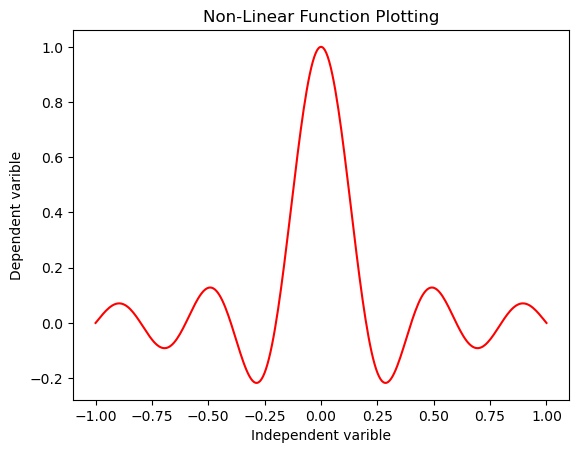

In [4]:
plt.plot(X, Y, color = "red")
plt.title('Non-Linear Function Plotting')
plt.xlabel('Independent varible')
plt.ylabel('Dependent varible')

In [5]:
class MathRegressor(nn.Module):
    def __init__(self, num_hidden=128):
        super().__init__()
        self.regressor = nn.Sequential(
            nn.Linear(1, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, 1)
        )

    def forward(self, x):
        x = self.regressor(x)
        return x
    
    def training_step(self, batch,loss_fn):
        inputs, targets = batch 
        out = self(inputs)                 # Generate predictions
        loss = loss_fn(out, targets)    # Calculate loss
        return loss
    
    def validation_step(self, batch,loss_fn):
        inputs, targets = batch 
        out = self(inputs)                 # Generate predictions
        loss = loss_fn(out, targets)    # Calculate loss
        return {'val_loss': loss.detach()}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def train_step(self, batch,loss_fn):
        inputs, targets = batch 
        out = self(inputs)                 # Generate predictions
        loss = loss_fn(out, targets)    # Calculate loss
        return {'train_loss': loss.detach()}
    
    def train_epoch_end(self, outputs):
        batch_losses = [x['train_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'train_loss': epoch_loss.item()}
    
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}".format(epoch, result['val_loss']))
    

In [6]:
def compute_gradient_norm(model, criterion, train, target):
    model.train()
    model.zero_grad()
    output = model(train)
    loss = criterion(output, target)
    loss.backward()

    grads = []
    for p in model.regressor.children():
        if isinstance(p, nn.Linear):
            param_norm = p.weight.grad.norm(2).item()
            grads.append(param_norm)

    grad_mean = np.mean(grads) 

    return grad_mean

def save_activations(layer, A, _):
    activations[layer] = A

def compute_hess(layer, _, B):
    A = activations[layer]
    BA = torch.einsum('nl,ni->nli', B, A) 
    hess[layer] += torch.einsum('nli,nkj->likj', BA, BA)
    
def compute_minimum_ratio(model, criterion, train, target):
    model.zero_grad()
    
    with autograd_lib.module_hook(save_activations):
        output = model(train)
        loss = criterion(output, target)

    with autograd_lib.module_hook(compute_hess):
        autograd_lib.backward_hessian(output, loss='LeastSquares')

    layer_hess = list(hess.values())
    minimum_ratio = []

    for h in layer_hess:
        size = h.shape[0] * h.shape[1]
        h = h.reshape(size, size)
        h_eig = torch.linalg.eigh(h)[0]  # Get only the eigenvalues
        num_greater = torch.sum(h_eig > 0).item()
        minimum_ratio.append(num_greater / len(h_eig))

    ratio_mean = np.mean(minimum_ratio) 

    return ratio_mean

In [7]:
def get_norm_minimal_ratio(model,criterion):
    gradient_norm = compute_gradient_norm(model, criterion, X, Y)
    minimum_ratio = compute_minimum_ratio(model, criterion, X, Y)

    print('gradient norm: {}, minimum ratio: {}'.format(gradient_norm, minimum_ratio))
    result = {}
    result["grad_norm"] = gradient_norm
    result["ratio"] = minimum_ratio
    
    return result

In [8]:
def evaluate(model,loss_fn, val_loader):
    outputs = [model.validation_step(batch,loss_fn) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, data_loader, criterion,opt_func):
    history = []
    grad_norm_per_epoch={}

    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        optimizer.zero_grad()   # clear gradients for next train
    
        # Training Phase 
        prediction = model(X)
        loss = criterion(prediction, Y)     # must be (1. nn output, 2. target)
        loss.backward()         # backpropagation, compute gradients
                
        grad_norm_per_epoch[epoch] = get_norm_minimal_ratio(model,criterion)
        
        optimizer.step() 
        optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model,criterion, data_loader)
        model.epoch_end(epoch, result)
        history.append(result)
  
    return history,grad_norm_per_epoch,model

In [9]:
#setup parameters
lr = 0.0004
gamma_lr_scheduler = 0.1 
criterion = nn.MSELoss()
optimizer = torch.optim.Adam
num_epochs =100

In [10]:
model= MathRegressor()

In [11]:
autograd_lib.register(model)
activations = defaultdict(int)
hess = defaultdict(float)

In [12]:
result_1 = evaluate(model,criterion,data_loader)
result_1

/home/hasan2/.local/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


{'val_loss': 0.17534957826137543}

In [13]:
train,target = X,Y

In [14]:
history_1,grad_norm_1,model_1  = fit(num_epochs, lr, model, data_loader, criterion,optimizer)

gradient norm: 1.3272387273609638, minimum ratio: 0.703125
Epoch [0], val_loss: 0.1842
gradient norm: 1.393603229895234, minimum ratio: 0.69140625
Epoch [1], val_loss: 0.1934
gradient norm: 1.4600272439420223, minimum ratio: 0.7265625
Epoch [2], val_loss: 0.2031
gradient norm: 1.5265095680952072, minimum ratio: 0.6875
Epoch [3], val_loss: 0.2132
gradient norm: 1.5930377747863531, minimum ratio: 0.71484375
Epoch [4], val_loss: 0.2238
gradient norm: 1.65960599668324, minimum ratio: 0.6875
Epoch [5], val_loss: 0.2348
gradient norm: 1.72620870731771, minimum ratio: 0.7421875
Epoch [6], val_loss: 0.2463
gradient norm: 1.7928659599274397, minimum ratio: 0.70703125
Epoch [7], val_loss: 0.2582
gradient norm: 1.8595834914594889, minimum ratio: 0.70703125
Epoch [8], val_loss: 0.2705
gradient norm: 1.9263307675719261, minimum ratio: 0.7109375
Epoch [9], val_loss: 0.2833
gradient norm: 1.9931526631116867, minimum ratio: 0.7421875
Epoch [10], val_loss: 0.2965
gradient norm: 2.06000598333776, minimu

In [15]:
grad_norm_1

{0: {'grad_norm': 1.3272387273609638, 'ratio': 0.703125},
 1: {'grad_norm': 1.393603229895234, 'ratio': 0.69140625},
 2: {'grad_norm': 1.4600272439420223, 'ratio': 0.7265625},
 3: {'grad_norm': 1.5265095680952072, 'ratio': 0.6875},
 4: {'grad_norm': 1.5930377747863531, 'ratio': 0.71484375},
 5: {'grad_norm': 1.65960599668324, 'ratio': 0.6875},
 6: {'grad_norm': 1.72620870731771, 'ratio': 0.7421875},
 7: {'grad_norm': 1.7928659599274397, 'ratio': 0.70703125},
 8: {'grad_norm': 1.8595834914594889, 'ratio': 0.70703125},
 9: {'grad_norm': 1.9263307675719261, 'ratio': 0.7109375},
 10: {'grad_norm': 1.9931526631116867, 'ratio': 0.7421875},
 11: {'grad_norm': 2.06000598333776, 'ratio': 0.7109375},
 12: {'grad_norm': 2.1269011609256268, 'ratio': 0.69921875},
 13: {'grad_norm': 2.1938791386783123, 'ratio': 0.69921875},
 14: {'grad_norm': 2.2609098628163338, 'ratio': 0.71484375},
 15: {'grad_norm': 2.327999822795391, 'ratio': 0.70703125},
 16: {'grad_norm': 2.395144861191511, 'ratio': 0.69921875

In [16]:
val_losses_1 = [r['val_loss'] for r in history_1]
len(val_losses_1)

100

In [17]:
minimal_ratio_eps = [i['ratio'] for i in grad_norm_1.values() ]

[]

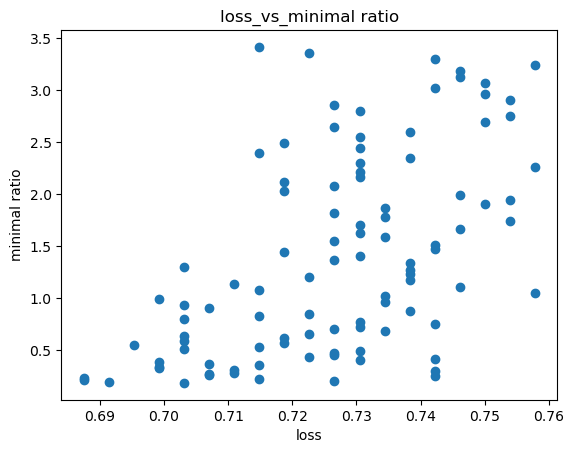

In [20]:
plt.scatter(minimal_ratio_eps, val_losses_1)
plt.xlabel('loss')
plt.ylabel('minimal ratio')
plt.title('loss_vs_minimal ratio');
plt.plot()